In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

from IPython.display import display

In [2]:
NUM_STATES = 4
NUM_OBSERVATIONS = 2
NUM_BELIEFS = 2 # TARGET vs. NON TARGET
ANGLE_RANGE = 2*np.pi

STATE_STEP = ANGLE_RANGE/NUM_STATES
STATE_CENTERS = np.arange(0, ANGLE_RANGE, STATE_STEP) + STATE_STEP
ANGL_DIST_BETWEEN_STATES = (STATE_CENTERS[np.newaxis, :] - STATE_CENTERS[:, np.newaxis])

PRIOR_TARGET_PROB = np.array([1/NUM_BELIEFS, 1-(1/NUM_BELIEFS)])
PRIOR_STATE_PROB = np.full(NUM_STATES, 1/NUM_STATES)
LIKELIHOOD_OBS_FROM_NONTARGET = 1/NUM_OBSERVATIONS

In [3]:
STATE_STEP

1.5707963267948966

In [4]:
def get_state_transition_matrix(candidate_step):
    if candidate_step>0:
        mod_basis = 2*np.pi
    else:
        mod_basis = -2*np.pi

    angular_dist_between_states_in_extent = ANGL_DIST_BETWEEN_STATES % mod_basis
    angular_dist_after_action = (angular_dist_between_states_in_extent - candidate_step)
    angular_dist_after_action_in_extent = angular_dist_after_action % mod_basis
    
    sigma = STATE_STEP/10
    magnitude = 1 / np.sqrt((2*np.pi) * (sigma**2))
    state_transition = magnitude * np.exp(-0.5*((angular_dist_after_action_in_extent/sigma)**2))
    state_transition_normed = state_transition / state_transition.sum(axis=1)
    return state_transition_normed

In [5]:
candidate_step = -STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [6]:
candidate_step = STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [7]:
obs1_bounds = np.array([60, 120])

In [8]:
def observe_angle_state_pair(initial_angle):
   plt.figure(figsize=(6, 6))
   radius = 1
   radius_until = 5
   pie = np.pi
   theta_obs1 = np.linspace(np.radians(obs1_bounds[0]), np.radians(obs1_bounds[1]), 30)
   x_inner = radius * np.cos(theta_obs1)
   y_inner =  radius * np.sin(theta_obs1)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='blue', linewidth=1)

   theta_obs0 = np.linspace(np.radians(obs1_bounds[1]), np.radians(obs1_bounds[0])+2*pie, 30)
   x_inner = radius * np.cos(theta_obs0)
   y_inner =  radius * np.sin(theta_obs0)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='orange', linewidth=1)

   for theta in STATE_CENTERS:
      r_outer = 4 * radius_until * radius
      plt.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
               [radius*np.sin(theta), r_outer*np.sin(theta)],
                  color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
      plt.plot([radius*np.cos(theta + (STATE_STEP/2)), r_outer*np.cos(theta + (STATE_STEP/2))], 
               [radius*np.sin(theta + (STATE_STEP/2)), r_outer*np.sin(theta + (STATE_STEP/2))],
                  color='k', linewidth=1, linestyle='dashed', zorder=1)
      
   if initial_angle >= obs1_bounds[0] and initial_angle <= obs1_bounds[1]:
      code_received = 1
   else:
      code_received = 0
   initial_radians = np.radians((initial_angle % 360))
   initial_state = np.floor((initial_radians) / STATE_STEP)
   plt.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}')

   plt.gca().set_aspect('equal', adjustable='box')
   plt.xticks([])
   plt.yticks([])
   GRID_EXTENT = 7
   plt.xlim(-GRID_EXTENT, GRID_EXTENT)
   plt.ylim(-GRID_EXTENT, GRID_EXTENT)
   plt.legend()
   plt.show()


In [9]:
initial_angle_slider = widgets.IntSlider(
    value=0,  
    min=0,
    max=360,
    description="Initial Angle",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="600px"),
)

interactive_plot = widgets.interactive(
    observe_angle_state_pair, initial_angle=initial_angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Initial Angle', layout=Layout(width='600px'), max=360, s…

In [10]:
code0_extent_in_states = np.zeros(NUM_STATES) + STATE_STEP
code0_extent_in_states[1] = 0
code1_extent_in_states = np.zeros(NUM_STATES)
code1_extent_in_states[1] = STATE_STEP

prob_code0_in_states = code0_extent_in_states / STATE_STEP
prob_code1_in_states = code1_extent_in_states / STATE_STEP

EMISSION_MATRIX_B = np.vstack([prob_code0_in_states, prob_code1_in_states])
EMISSION_MATRIX_B

array([[1., 0., 1., 1.],
       [0., 1., 0., 0.]])

In [12]:
max_iter = 10
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 0

Current angle: 0.0, Code received: 0.0


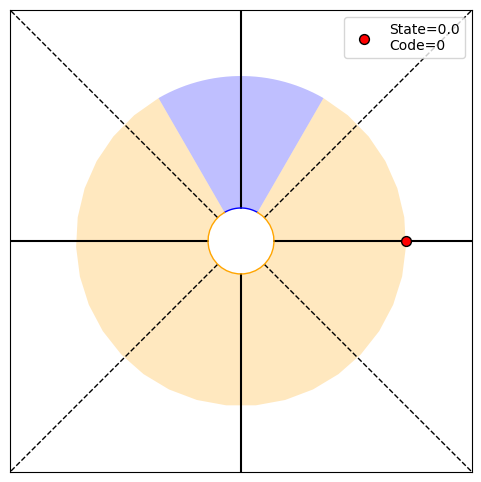

P(O1,S1|T)=[0.25 0.   0.25 0.25], P(O1|T)=0.75, P(T|O1)=[0.6 0.4], H1=0.97


In [13]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,S1|T)={joint_prob_received_obs_state_t[time_ind]}, P(O1|T)={likelihood_received_obs_from_target_t[time_ind]}, P(T|O1)={posterior_t[time_ind]}, H1={current_entropyS_t[time_ind]:.2f}")

In [14]:
step_to_take = -STATE_STEP
time_ind+=1
step_to_take, time_ind

(-1.5707963267948966, 1)

Current angle: -90.0, Code received: 0.0


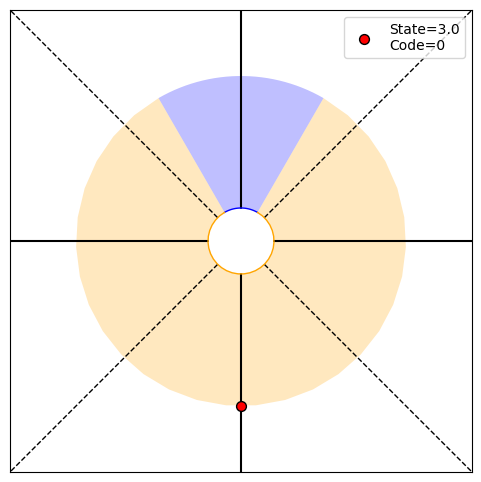

P(O1,O2,S2|T)=[0.   0.   0.25 0.25], P(O1,O2|Δθ2,T)=0.5, P(O2|O1,Δθ2,T)=0.67, P(T|O2,O1,Δθ2)=[0.67 0.33], H1=0.92


In [15]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,O2,S2|T)={np.round(joint_prob_received_obs_state_t[time_ind],2)}, P(O1,O2|Δθ2,T)={likelihood_received_obs_from_target_t[time_ind]}, P(O2|O1,Δθ2,T)={likelihood_received_obs_from_target_given_obs_sequence:.2f}, P(T|O2,O1,Δθ2)={np.round(posterior_t[time_ind], 2)}, H1={current_entropyS_t[time_ind]:.2f}")

In [16]:
max_iter = 10
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 0

Current angle: 0.0, Code received: 0.0


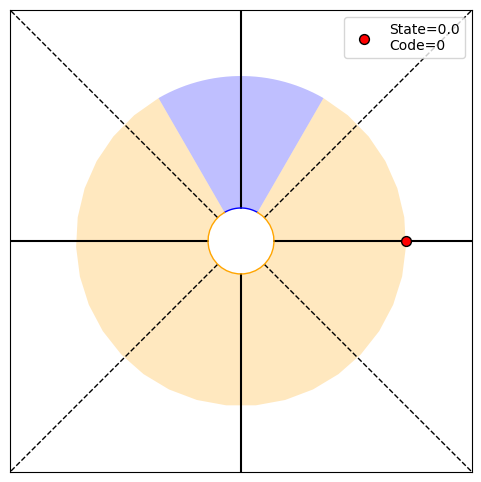

P(O1,S1|T)=[0.25 0.   0.25 0.25], P(O1|T)=0.75, P(T|O1)=[0.6 0.4], H1=0.97


In [17]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,S1|T)={joint_prob_received_obs_state_t[time_ind]}, P(O1|T)={likelihood_received_obs_from_target_t[time_ind]}, P(T|O1)={posterior_t[time_ind]}, H1={current_entropyS_t[time_ind]:.2f}")

In [18]:
step_to_take = STATE_STEP
time_ind+=1
step_to_take, time_ind

(1.5707963267948966, 1)

Current angle: 90.0, Code received: 1.0


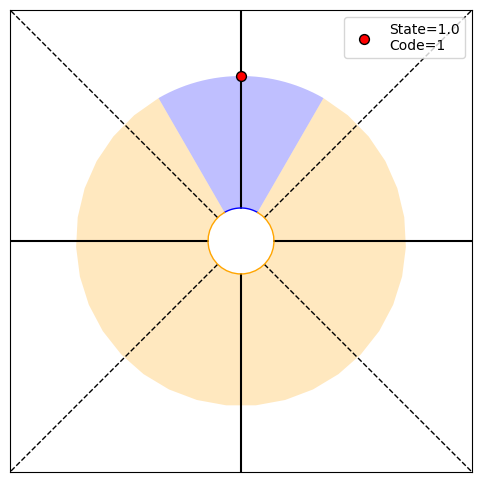

P(O1,O2,S2|T)=[0.   0.25 0.   0.  ], P(O1,O2|Δθ2,T)=0.25, P(O2|O1,Δθ2,T)=0.33, P(T|O2,O1,Δθ2)=[0.5 0.5], H1=1.00


In [19]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,O2,S2|T)={np.round(joint_prob_received_obs_state_t[time_ind],2)}, P(O1,O2|Δθ2,T)={likelihood_received_obs_from_target_t[time_ind]}, P(O2|O1,Δθ2,T)={likelihood_received_obs_from_target_given_obs_sequence:.2f}, P(T|O2,O1,Δθ2)={np.round(posterior_t[time_ind], 2)}, H1={current_entropyS_t[time_ind]:.2f}")

In [20]:
max_iter = 10
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 90

Current angle: 90.0, Code received: 1.0


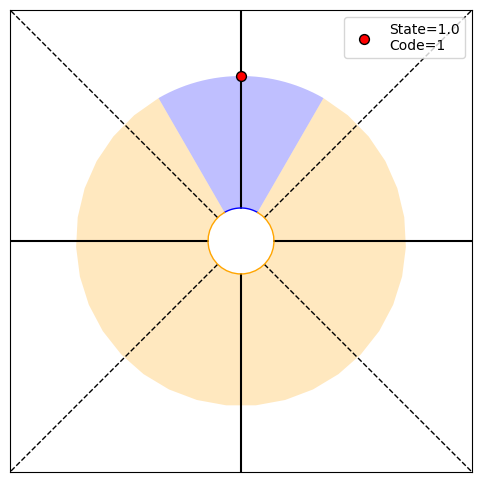

P(O1,S1|T)=[0.   0.25 0.   0.  ], P(O1|T)=0.25, P(T|O1)=[0.33333333 0.66666667], H1=0.92


In [21]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,S1|T)={joint_prob_received_obs_state_t[time_ind]}, P(O1|T)={likelihood_received_obs_from_target_t[time_ind]}, P(T|O1)={posterior_t[time_ind]}, H1={current_entropyS_t[time_ind]:.2f}")

In [22]:
step_to_take = -STATE_STEP
time_ind+=1
step_to_take, time_ind

(-1.5707963267948966, 1)

Current angle: 0.0, Code received: 0.0


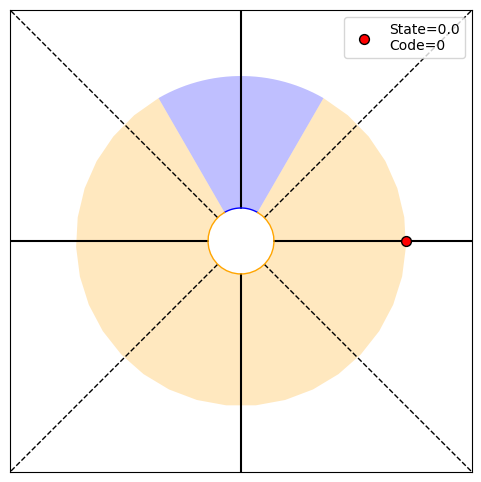

P(O1,O2,S2|T)=[0.25 0.   0.   0.  ], P(O1,O2|Δθ2,T)=0.25, P(O2|O1,Δθ2,T)=1.00, P(T|O2,O1,Δθ2)=[0.5 0.5], H1=1.00


In [23]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,O2,S2|T)={np.round(joint_prob_received_obs_state_t[time_ind],2)}, P(O1,O2|Δθ2,T)={likelihood_received_obs_from_target_t[time_ind]}, P(O2|O1,Δθ2,T)={likelihood_received_obs_from_target_given_obs_sequence:.2f}, P(T|O2,O1,Δθ2)={np.round(posterior_t[time_ind], 2)}, H1={current_entropyS_t[time_ind]:.2f}")

In [24]:
max_iter = 10
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 90

Current angle: 90.0, Code received: 1.0


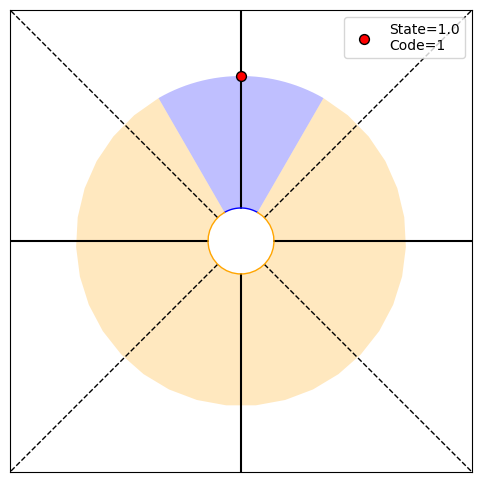

P(O1,S1|T)=[0.   0.25 0.   0.  ], P(O1|T)=0.25, P(T|O1)=[0.33333333 0.66666667], H1=0.92


In [25]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,S1|T)={joint_prob_received_obs_state_t[time_ind]}, P(O1|T)={likelihood_received_obs_from_target_t[time_ind]}, P(T|O1)={posterior_t[time_ind]}, H1={current_entropyS_t[time_ind]:.2f}")

In [26]:
step_to_take = STATE_STEP
time_ind+=1
step_to_take, time_ind

(1.5707963267948966, 1)

Current angle: 180.0, Code received: 0.0


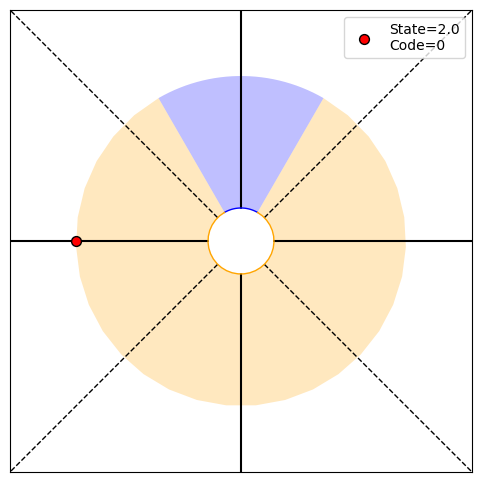

P(O1,O2,S2|T)=[0.   0.   0.25 0.  ], P(O1,O2|Δθ2,T)=0.25, P(O2|O1,Δθ2,T)=1.00, P(T|O2,O1,Δθ2)=[0.5 0.5], H1=1.00


In [27]:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

print(f"P(O1,O2,S2|T)={np.round(joint_prob_received_obs_state_t[time_ind],2)}, P(O1,O2|Δθ2,T)={likelihood_received_obs_from_target_t[time_ind]}, P(O2|O1,Δθ2,T)={likelihood_received_obs_from_target_given_obs_sequence:.2f}, P(T|O2,O1,Δθ2)={np.round(posterior_t[time_ind], 2)}, H1={current_entropyS_t[time_ind]:.2f}")